In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## OUTLIER DETECTION ON PLAYERS

IMPORT NECESSARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

FUNCTION TO LOAD THE DATASET

In [2]:
def load_data(file_name, delimiter=','):
  return pd.read_csv(file_name, delimiter=delimiter)

FUNCTION TO CALCULATE EFFICIENCY RATING

In [3]:
def calculate_basic_eff_rating(data):
  EFF_Rating = (data['pts'] + data['reb'] + data['asts']) / data['gp']
  return EFF_Rating

FUNCTION TO DISPLAY A SAMPLE OF THE OUTLIERS

In [4]:
def display_outliers(dataset):
  outliers = dataset[dataset['Outlier'] == 0]
  total_players = len(dataset)
  total_outliers = len(outliers)

  print(f"Total Players: {total_players}")
  print(f"Total Outstanding Players (Outliers): {total_outliers}")
  count_row = outliers.shape[0]
  if count_row <= 10 and count_row > 0:
    print(outliers.to_string())
    pass
  elif count_row > 10:
    print("\nSample of Outstanding Players (Outliers - First 5 and Last 5 Values):\n")
    if total_outliers > 0:
      with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.colheader_justify', 'center'):
        print(pd.concat([outliers.head(5), outliers.tail(5)]).to_string(index=False))
  else:
    print("No outliers detected.")


In [5]:
def display_outliers_offensive(dataset):
  outliers = dataset[dataset['Outlier'] == 0]
  outliers.sort_values(by=['Basic EFF Rating'])
  total_players = len(dataset)
  total_outliers = len(outliers)

  print(f"Total Players: {total_players}")
  print(f"Total Outstanding Players (Outliers): {total_outliers}")

  count_row = outliers.shape[0]
  if count_row <= 10 and count_row > 0:
    print(outliers.to_string())
    pass
  elif count_row > 10:
    print("\nSample of Outstanding Players (Outliers - First 5 and Last 5 Values):\n")
    if total_outliers > 0:
      with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000, 'display.colheader_justify', 'center'):
        print(pd.concat([outliers.head(5), outliers.tail(5)]).to_string(index=False))
  else:
    print("No outliers detected.")


FUNCTION TO VISUALIZE OUTLIER DETECTION RESULTS FOR UNSUPERVISED CLASSIFIER

In [6]:
def plot_outlier_detection(player_stats, focused_stats, features_pca):
    inliers = player_stats.loc[focused_stats.index][player_stats['Outlier'] == 1]
    outliers = player_stats.loc[focused_stats.index][player_stats['Outlier'] == 0]
    plt.scatter(features_pca[inliers.index - focused_stats.index[0], 0],features_pca[inliers.index - focused_stats.index[0], 1],color='blue',alpha=0.6, label='Inliers')
    plt.scatter(features_pca[outliers.index - focused_stats.index[0], 0],features_pca[outliers.index - focused_stats.index[0], 1],color='red', alpha=0.6,label='Outliers')
    plt.xlabel('PCA_1')
    plt.ylabel('PCA_2')
    plt.title('Outlier Detection')
    plt.legend()
    plt.show()


In [7]:
def plot_outlier_detection_offensive(dataset):
  plt.figure(figsize=(10, 6))
  plt.scatter(dataset['minutes'], dataset['Basic EFF Rating'], c=dataset['Outlier'], cmap='coolwarm_r', alpha=0.6)
  plt.title('Outlier Detection in Player Performance')
  plt.xlabel('Minutes')
  plt.ylabel('Basic EFF Rating')
  plt.colorbar(label='Outlier (0) / Inlier (1)')
  plt.axhline(0, color='grey', lw=1, ls='--')
  plt.axvline(0, color='grey', lw=1, ls='--')
  plt.legend()
  plt.show()

FUNCTION FOR OUTLIER DETECTION

In [8]:
def find_outstanding_offensive_players(stats_file,year, delimiter=','):
  player_stats = load_data(stats_file, delimiter)

  player_stats = player_stats[player_stats['minutes'] > 0]
  player_stats = player_stats[player_stats['gp'] > 0]
  player_stats = player_stats[player_stats['year'] == year]

  # Calculate Basic EFF Rating
  player_stats['Basic EFF Rating'] = calculate_basic_eff_rating(player_stats)

  # Select relevant features
  features = player_stats[['Basic EFF Rating', 'pts', 'reb', 'asts', 'minutes']]

  # Scale the data
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features)

  #reduce dimensionality
  pca = PCA(n_components=2)
  features_pca = pca.fit_transform(features_scaled)

  # Initialize classifiers

  print("\n Isolation Forest")
  p1 = player_stats.copy()
  iso_forest = IsolationForest(contamination=0.02, random_state=42)
  p1['Outlier'] = iso_forest.fit_predict(features_pca)
  p1['Outlier'] = p1['Outlier'].map({-1: 0, 1: 1})
  display_outliers_offensive(p1)
  outliers1 = p1[p1['Outlier'] == 0]
  ave = outliers1["Basic EFF Rating"].mean()
  print("Average EFF Rating of Outliers: " + str(ave))
  plot_outlier_detection_offensive(p1)


  print("\n One-Class SVM")
  p2 = player_stats.copy()
  svm_model = OneClassSVM(nu=0.009, kernel="rbf", gamma=0.005)
  p2['Outlier'] = svm_model.fit_predict(features_pca)
  p2['Outlier'] = p2['Outlier'].map({-1: 0, 1: 1})
  display_outliers_offensive(p2)
  outliers2 = p2[p2['Outlier'] == 0]
  ave = outliers2["Basic EFF Rating"].mean()
  print("Average EFF Rating of Outliers: " + str(ave))
  plot_outlier_detection_offensive(p2)

  print("\n SGD One-Class SVM")
  p3 = player_stats.copy()
  svm_sgd = linear_model.SGDOneClassSVM(random_state=42,nu=0.8)
  p3['Outlier'] = svm_sgd.fit_predict(features_pca)
  p3['Outlier'] = p3['Outlier'].map({-1: 1, 1: 0})
  display_outliers_offensive(p3)
  outliers3 = p3[p3['Outlier'] == 0]
  ave = outliers3["Basic EFF Rating"].mean()
  print("Average EFF Rating of Outliers: " + str(ave))
  plot_outlier_detection_offensive(p3)

In [9]:
def find_outstanding_players(stats_file,year,column_start,column_end,delimiter=','):
  player_stats = load_data(stats_file, delimiter)

  player_stats = player_stats[player_stats['minutes'] > 0]
  player_stats = player_stats[player_stats['gp'] > 0]
  if "year" in player_stats.columns:
    player_stats = player_stats[player_stats['year'] == year]
  focused_stats = player_stats.iloc[:, column_start: column_end].fillna(0)
  # Scale the data
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(focused_stats)

  #reduce dimensionality
  pca = PCA(n_components=2)
  features_pca = pca.fit_transform(features_scaled)

  # Initialize classifiers
  print("\n Isolation Forest")
  p1 = player_stats.copy()
  iso_forest = IsolationForest(contamination=0.02, random_state=42)
  p1['Outlier'] = iso_forest.fit_predict(features_pca)
  p1['Outlier'] = p1['Outlier'].map({-1: 0, 1: 1})
  display_outliers(p1)
  outliers1 = p1[p1['Outlier'] == 0]
  plot_outlier_detection(p1, focused_stats, features_pca)

  print("\n One-Class SVM")
  p2 = player_stats.copy()
  svm_model = OneClassSVM(nu=0.03, kernel="rbf", gamma=0.008)
  p2['Outlier'] = svm_model.fit_predict(features_pca)
  p2['Outlier'] = p2['Outlier'].map({-1: 0, 1: 1})
  display_outliers(p2)
  outliers2 = p2[p2['Outlier'] == 0]
  plot_outlier_detection(p2, focused_stats, features_pca)

  print("\n SGD One-Class SVM")
  p3 = player_stats.copy()
  svm_sgd = linear_model.SGDOneClassSVM(random_state=42,nu=0.7)
  p3['Outlier'] = svm_sgd.fit_predict(features_pca)
  p3['Outlier'] = p3['Outlier'].map({-1: 0, 1: 1})
  display_outliers(p3)
  outliers3 = p3[p3['Outlier'] == 0]
  plot_outlier_detection(p3, focused_stats, features_pca)

# CALL FUNCTION FOR OUTLIER DETECTION

In [10]:
year = 2000


 Isolation Forest
Total Players: 537
Total Outstanding Players (Outliers): 11

Sample of Outstanding Players (Outliers - First 5 and Last 5 Values):

  ilkid    year firstname  lastname  team leag  gp  minutes  pts  oreb  dreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Outlier
ALLENRA02  2000       Ray      Allen MIL   N    82   3129   1806  101   327   428  374  124   20    204.0   192 1309 628  392  348  467  202     0    
DUNCATI01  2000       Tim     Duncan SAS   N    82   3174   1820  259   738   997  245   70  192    242.0   247 1406 702  662  409   27    7     0    
GARNEKE01  2000     Kevin    Garnett MIN   N    81   3202   1784  219   702   921  401  111  145    230.0   204 1475 704  467  357   66   19     0    
HARDATI01  2000       Tim   Hardaway MIA   N    77   2613   1150   26   178   204  483   90    6    189.0   155 1042 408  181  145  517  189     0    
MUTOMDI01  2000   Dikembe    Mutombo TOT   N    75   2591    749  307   708  1015   76   29  2

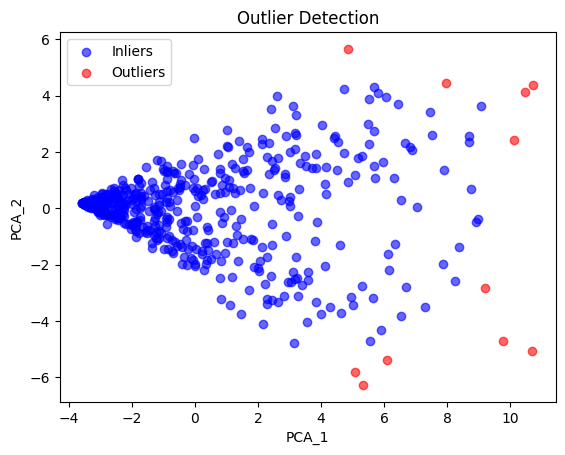


 One-Class SVM
Total Players: 537
Total Outstanding Players (Outliers): 17

Sample of Outstanding Players (Outliers - First 5 and Last 5 Values):

  ilkid    year firstname  lastname  team leag  gp  minutes  pts  oreb  dreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Outlier
ALLENRA02  2000      Ray       Allen MIL   N    82   3129   1806  101   327   428  374  124   20    204.0   192 1309 628  392  348  467  202     0    
DUNCATI01  2000      Tim      Duncan SAS   N    82   3174   1820  259   738   997  245   70  192    242.0   247 1406 702  662  409   27    7     0    
HARDATI01  2000      Tim    Hardaway MIA   N    77   2613   1150   26   178   204  483   90    6    189.0   155 1042 408  181  145  517  189     0    
IVERSAL01  2000    Allen     Iverson PHI   N    71   2979   2207   50   223   273  325  178   20    237.0   147 1813 762  719  585  306   98     0    
KETNELA01  2000     Lari      Ketner IND   N     3      7      0    0     0     0    1    0    0 

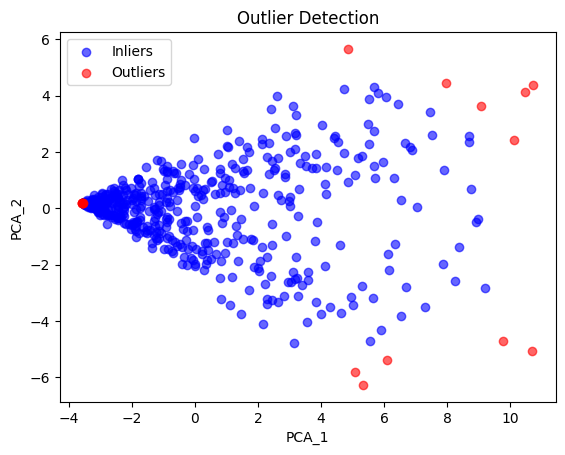


 SGD One-Class SVM
Total Players: 537
Total Outstanding Players (Outliers): 385

Sample of Outstanding Players (Outliers - First 5 and Last 5 Values):

  ilkid    year firstname   lastname  team leag  gp  minutes  pts  oreb  dreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Outlier
ABDULMA01  2000     Mahmo  Abdul-rauf VAN   N    41    486   266     5    20   25    76    9    1     26.0    50 246  120   29   22   14    4     0    
ABDULTA01  2000     Tariq Abdul-wahad DEN   N    29    420   111    14    45   59    22   14   13     34.0    54 111   43   36   21   10    4     0    
ALEXACO01  2000      Cory   Alexander ORL   N    24    222    52     0    25   25    36   16    0     25.0    29  56   18   18   12   16    4     0    
ALEXACO02  2000  Courtney   Alexander WAS   N    27    910   458    22    58   80    41   29    2     54.0    63 395  177  105   90   36   14     0    
ALEXACO02  2000  Courtney   Alexander DAL   N    38    472   160    20    43   63    21

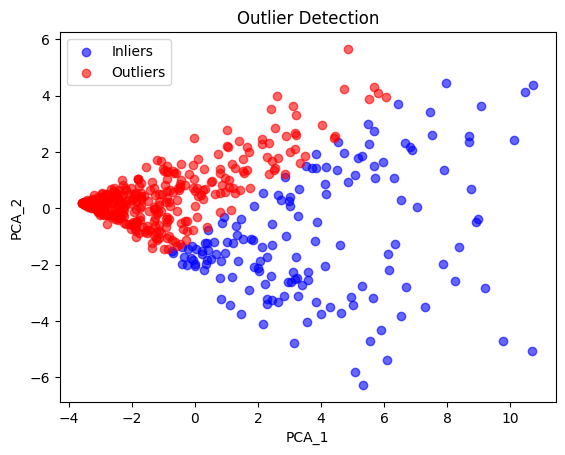

In [181]:
# player regular season
find_outstanding_players('/content/player_regular_season.txt', year,8,23,delimiter=',')


 Isolation Forest
Total Players: 190
Total Outstanding Players (Outliers): 4
           ilkid  year  firstname lastname team leag  gp  minutes  pts  dreb  oreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Outlier
6691  IVERSAL01   2000      Allen  Iverson  PHI    N  22     1016  723    89    15  104   134   52    7        63  55  661  257  208  161  142   48        0
6695  JOHNSER01   2000      Ervin  Johnson  MIL    N  18      577   98   135    59  194    10    9   37        12  52   68   39   32   20    0    0        0
6725  MUTOMDI01   2000    Dikembe  Mutombo  PHI    N  23      981  319   203   113  316    17   15   72        36  56  208  102  148  115    1    0        0
6733  ONEASH01    2000  Shaquille   O'neal  LAL    N  16      676  487   156    91  247    51    7   38        57  55  344  191  200  105    0    0        0


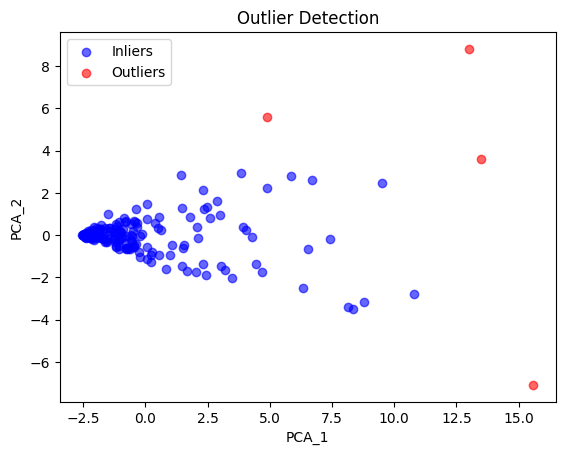


 One-Class SVM
Total Players: 190
Total Outstanding Players (Outliers): 6
           ilkid  year  firstname   lastname team leag  gp  minutes  pts  dreb  oreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Outlier
6604  ALLENRA02   2000        Ray      Allen  MIL    N  18      768  452    55    19   74   108   24   10        43  44  331  158   86   79  119   57        0
6691  IVERSAL01   2000      Allen    Iverson  PHI    N  22     1016  723    89    15  104   134   52    7        63  55  661  257  208  161  142   48        0
6700  KNIGHTR01   2000     Travis     Knight  NYK    N   1        1    0     0     0    0     0    0    0         0   1    0    0    0    0    0    0        0
6725  MUTOMDI01   2000    Dikembe    Mutombo  PHI    N  23      981  319   203   113  316    17   15   72        36  56  208  102  148  115    1    0        0
6733  ONEASH01    2000  Shaquille     O'neal  LAL    N  16      676  487   156    91  247    51    7   38        57  55  344  191 

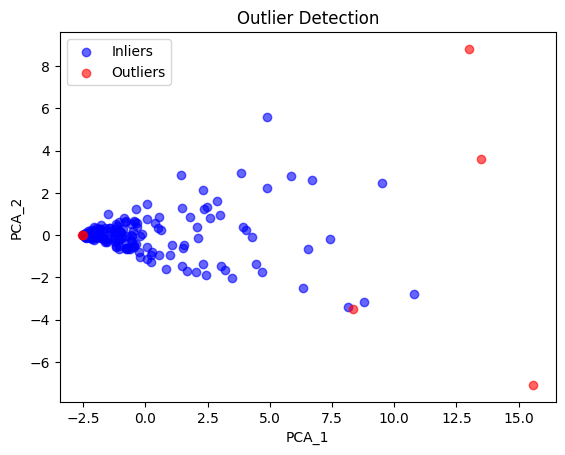


 SGD One-Class SVM
Total Players: 190
Total Outstanding Players (Outliers): 88

Sample of Outstanding Players (Outliers - First 5 and Last 5 Values):

  ilkid     year firstname  lastname team leag  gp  minutes  pts  dreb  oreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Outlier
ALLENRA02   2000      Ray      Allen MIL   N    18   768    452    55    19   74   108   24   10      43     44 331  158   86   79  119   57     0    
ANDERDE01   2000    Derek   Anderson SAS   N     7   194     54    16     3   19    17    3    0      15     10  61   16   21   16   22    6     0    
ARMSTDA01   2000  Darrell  Armstrong ORL   N     4   167     53    17     5   22    19    8    2      11     10  45   17   13   12   19    7     0    
BARRYJO01   2000      Jon      Barry SAC   N     7    55     16     0     3    3     4    1    0       3      7  17    7    0    0    7    2     0    
BELLRA01    2000     Raja       Bell PHI   N    15   124     34     9     4   13     7   15  

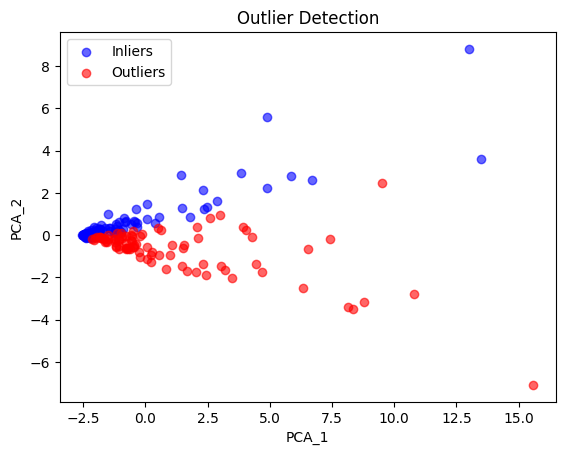

In [182]:
# player playoff
find_outstanding_players('/content/player_playoffs.txt', year,8,21,delimiter=',')

# The following finds outliers based on a basic EFF rating score

In [44]:
year = 1999


 Isolation Forest
Total Players: 537
Total Outstanding Players (Outliers): 11

Sample of Outstanding Players (Outliers - First 5 and Last 5 Values):

  ilkid    year firstname  lastname  team leag  gp  minutes  pts  oreb  dreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Basic EFF Rating  Outlier
BIBBYMI01  2000      Mike      Bibby VAN   N    82   3190   1301   47   257   304  685  107   12    248.0   148 1157 525  188  143  285  108      27.926829        0    
DUNCATI01  2000       Tim     Duncan SAS   N    82   3174   1820  259   738   997  245   70  192    242.0   247 1406 702  662  409   27    7      37.341463        0    
GARNEKE01  2000     Kevin    Garnett MIN   N    81   3202   1784  219   702   921  401  111  145    230.0   204 1475 704  467  357   66   19      38.345679        0    
JACKSMA01  2000      Mark    Jackson TOT   N    83   2588    631   63   242   305  661   84    7    175.0   139  583 244   93   73  207   70      19.240964        0    
 KID

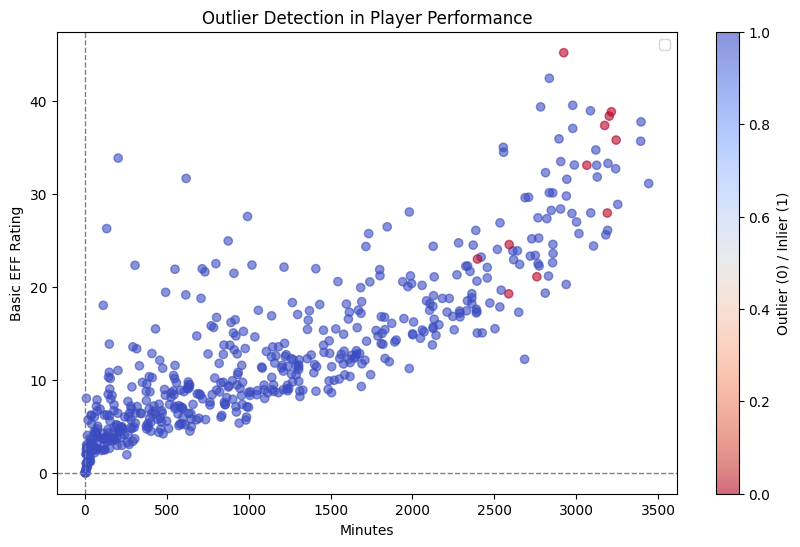


 One-Class SVM
Total Players: 537
Total Outstanding Players (Outliers): 4
           ilkid  year  firstname lastname team leag  gp  minutes   pts  oreb  dreb  reb  asts  stl  blk  turnover   pf   fga  fgm  fta  ftm  tpa  tpm  Basic EFF Rating  Outlier
16619  DUNCATI01  2000        Tim   Duncan  SAS    N  82     3174  1820   259   738  997   245   70  192     242.0  247  1406  702  662  409   27    7         37.341463        0
16735   KIDDJA01  2000      Jason     Kidd  PHO    N  77     3065  1299    91   403  494   753  166   23     286.0  171  1097  451  403  328  232   69         33.064935        0
16853   ONEASH01  2000  Shaquille   O'neal  LAL    N  74     2924  2125   291   649  940   277   47  204     218.0  256  1422  813  972  499    2    0         45.162162        0
16870  PAYTOGA01  2000       Gary   Payton  SEA    N  79     3244  1823    73   288  361   642  127   26     209.0  184  1591  725  354  271  272  102         35.772152        0
Average EFF Rating of Outliers: 37.

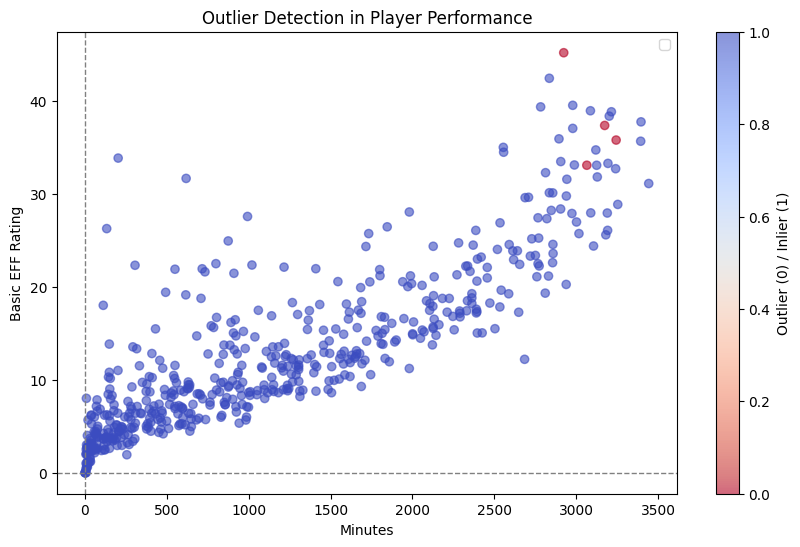


 SGD One-Class SVM
Total Players: 537
Total Outstanding Players (Outliers): 23

Sample of Outstanding Players (Outliers - First 5 and Last 5 Values):

  ilkid    year firstname   lastname   team leag  gp  minutes  pts  oreb  dreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Basic EFF Rating  Outlier
BRADLSH01  2000     Shawn      Bradley DAL   N    82   2001    579  160   448   608   38   36  228     88.0   256  447 219  178  140   6    1       14.939024        0    
BRANDEL01  2000     Elton        Brand CHI   N    74   2906   1490  285   461   746  240   71  118    219.0   243 1215 578  472  334   2    0       33.459459        0    
BROWNPJ01  2000      P.j.        Brown CHA   N    80   2811    676  257   485   742  127   78   92    108.0   260  561 249  209  178   4    0       19.312500        0    
CAMBYMA01  2000    Marcus        Camby NYK   N    63   2127    759  196   527   723   52   66  136     63.0   205  580 304  225  150   8    1       24.349206       

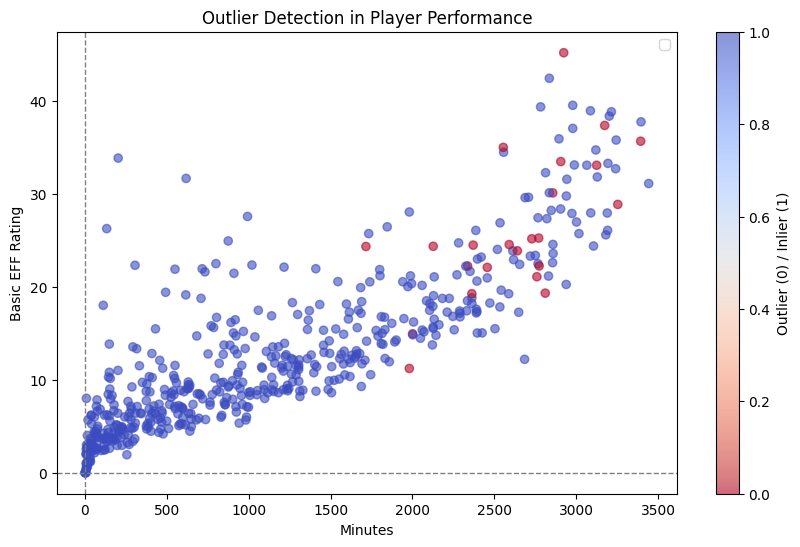

In [213]:
find_outstanding_offensive_players('/content/player_regular_season.txt', year,delimiter=',')


 Isolation Forest


Total Players: 190
Total Outstanding Players (Outliers): 4
           ilkid  year  firstname lastname team leag  gp  minutes  pts  dreb  oreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Basic EFF Rating  Outlier
6691  IVERSAL01   2000      Allen  Iverson  PHI    N  22     1016  723    89    15  104   134   52    7        63  55  661  257  208  161  142   48         43.681818        0
6695  JOHNSER01   2000      Ervin  Johnson  MIL    N  18      577   98   135    59  194    10    9   37        12  52   68   39   32   20    0    0         16.777778        0
6725  MUTOMDI01   2000    Dikembe  Mutombo  PHI    N  23      981  319   203   113  316    17   15   72        36  56  208  102  148  115    1    0         28.347826        0
6733  ONEASH01    2000  Shaquille   O'neal  LAL    N  16      676  487   156    91  247    51    7   38        57  55  344  191  200  105    0    0         49.062500        0
Average EFF Rating of Outliers: 34.46748051163812


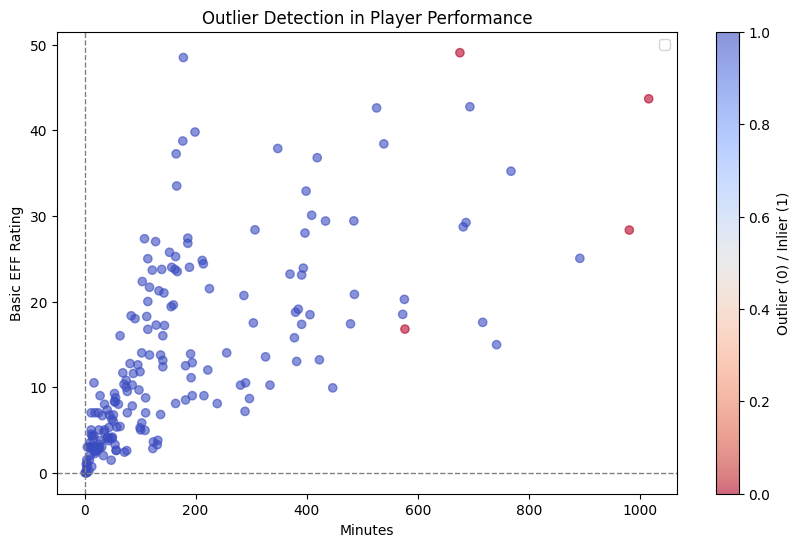


 One-Class SVM
Total Players: 190
Total Outstanding Players (Outliers): 2
           ilkid  year firstname lastname team leag  gp  minutes  pts  dreb  oreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Basic EFF Rating  Outlier
6700  KNIGHTR01   2000    Travis   Knight  NYK    N   1        1    0     0     0    0     0    0    0         0   1    0    0    0    0    0    0          0.000000        0
6725  MUTOMDI01   2000   Dikembe  Mutombo  PHI    N  23      981  319   203   113  316    17   15   72        36  56  208  102  148  115    1    0         28.347826        0
Average EFF Rating of Outliers: 14.173913043478262


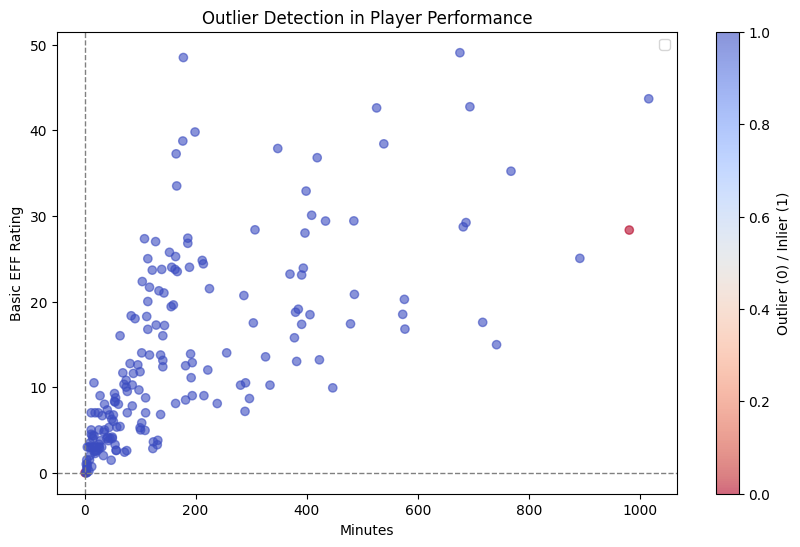


 SGD One-Class SVM
Total Players: 190
Total Outstanding Players (Outliers): 28

Sample of Outstanding Players (Outliers - First 5 and Last 5 Values):

  ilkid     year firstname lastname team leag  gp  minutes  pts  dreb  oreb  reb  asts  stl  blk  turnover  pf  fga  fgm  fta  ftm  tpa  tpm  Basic EFF Rating  Outlier
ALLENRA02   2000     Ray      Allen MIL   N    18   768    452    55    19   74   108   24   10      43     44 331  158   86   79  119   57      35.222222        0    
BRYANKO01   2000    Kobe     Bryant LAL   N    16   694    471    87    29  116    97   25   12      51     53 358  168  151  124   34   11      42.750000        0    
CARTEVI01   2000   Vince     Carter TOR   N    12   539    327    41    37   78    56   20   20      27     45 280  122   74   58   61   25      38.416667        0    
CASSESA01   2000     Sam    Cassell MIL   N    18   682    314    71    12   83   120   19    3      52     76 278  110   97   84   30   10      28.722222        0    
CHILDCH0

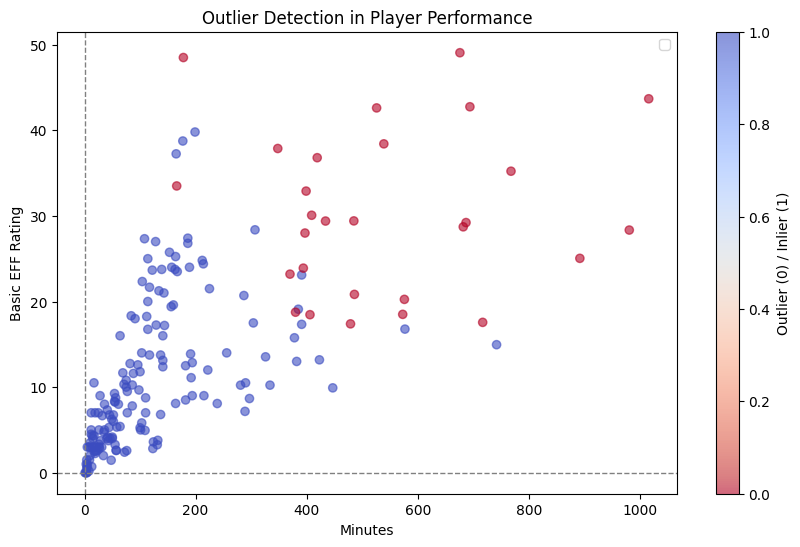

In [214]:
find_outstanding_offensive_players('/content/player_playoffs.txt', year,delimiter=',')